In [28]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)


dat = pd.read_csv('crimeny.csv')
df_or = pd.DataFrame(dat)

#Some basic data cleaning here (ASK MUKESH ABOUT FURTHER DATA CLEANING)

# this is a good command to make all column names upper/lower case
# df.columns = map(str.lower, df.columns), not needed here as I am renaming columns manually


#Remove empty columns of data here (NaN)
df_or = df_or.dropna(subset = ['Population', 'City'])
df_or = df_or.drop('Unnamed: 13', axis=1)
df_or = df_or.drop(df_or.columns[4], axis = 1) #'Rape (revised definition)1'

#Remove commas from the numbers in all data, standardize all the numbers for the future
df_or = df_or.replace(',', '', regex=True)

#Renaming columns for consistency and ease of typing
df = df_or.rename({'Robbery':'robbery',
               df_or.columns[0]:'city',
               df_or.columns[1]:'population', 
               df_or.columns[2]:'violent crime',
               df_or.columns[3]:'murder',
               df_or.columns[4]:'rape',
               df_or.columns[6]:'assault',
               df_or.columns[7]:'property crime',
               df_or.columns[8]:'burglary',
               df_or.columns[9]:'larceny',
               df_or.columns[10]:'motor vehicle theft',
               df_or.columns[11]:'arson'}, 
               axis='columns')
#This is 1 line of code that changes all columns to numeric (except the columns I exclude)
#This also fills NAN values to 0, this removes decimals from the data and allows us to 
#perform math functions on the data since it is not strings anymore

df.loc[:, df.columns != 'city'] = df.loc[:, df.columns != 'city'].apply(pd.to_numeric, 
                                        errors='coerce').fillna(0, downcast='infer')
df.head()

,city,population,violent crime,murder,rape,robbery,assault,property crime,burglary,larceny,motor vehicle theft,arson
0,Adams Village,1851,0,0,0,0,0,11,1,10,0,0
1,Addison Town and Village,2568,2,0,0,1,1,49,1,47,1,0
2,Afton Village4,820,0,0,0,0,0,1,0,1,0,0
3,Akron Village,2842,1,0,0,0,1,17,0,17,0,0
4,Albany4,98595,802,8,0,237,503,3888,683,3083,122,12


In [29]:
from scipy import stats

z = np.abs(stats.zscore(df.loc[:, df.columns != 'city']))
# get indices of outliers
outliers= list(np.where(z > 3)[0])
# drop them
df= df.drop(outliers)

#Now for the assignment portion:

# As per instructions: Create new feature of population^2
df['population^2'] = np.power(df['population'], 2)

#as per instructions for robbery and murder: 
# "For this model, please use these variables to create categorical 
# features where values greater than 0 are coded 1, and values equal to 0 are coded 0."" 
df.murder[df.murder >= 1] = 1
df.murder[df.murder < 1] = 0

df.robbery[df.robbery >= 1] = 1
df.robbery[df.robbery < 1] = 0

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [31]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['property crime'].values.reshape(-1, 1)
X = df[['murder','population^2','robbery', 'population']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 2.61954548e+02 -6.54013155e-08  7.47367437e+00  2.44120744e-02]]

Intercept: 
 [-66.11545932]

R-squared:
0.7354709125473062


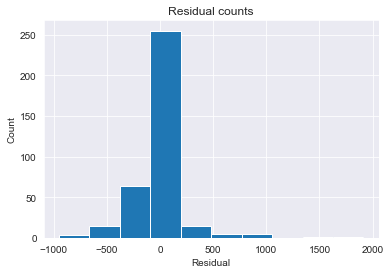

In [32]:
predicted = regr.predict(X).ravel()
actual = df['property crime']

sns.set_style('darkgrid')
# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

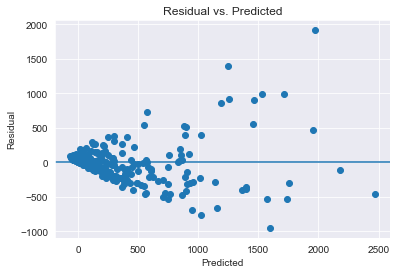

In [33]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


In [34]:
correlation_matrix = X.corr()
display(correlation_matrix)

,murder,population^2,robbery,population
murder,1.000,0.383,0.296,0.560
population^2,0.383,1.000,0.203,0.853
robbery,0.296,0.203,1.000,0.437
population,0.560,0.853,0.437,1.000


In [35]:
robbery = df.robbery
murder = df.murder
propertycrime = df['property crime']
population2 = df['population^2']
population = df['population']

In [36]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'propertycrime ~ murder+robbery+population2+population'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df).fit()

In [37]:
lm.params

Intercept     -66.115
murder        261.954
robbery         7.474
population2    -0.000
population      0.024
dtype: float64

In [38]:
lm.pvalues

Intercept     0.001
murder        0.000
robbery       0.812
population2   0.000
population    0.000
dtype: float64

In [39]:
lm.rsquared

0.7354709125472965

In [42]:
#lets remove robbery (p-value higher than .05)
linear_formula = 'propertycrime ~ murder+population+population2'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df).fit()

In [43]:
lm.rsquared

0.7354290544359117

In [ ]:
#Our model is consistent across multiple datasets: New York crime 2013 and New York Crime 2014
#Both models return same r-squared: 0.73